In [1]:
%matplotlib inline
import torch, torchvision
from torchvision.transforms import ToTensor, Resize
from torchvision import transforms
import os
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import copy
import numpy as np
from torch.utils.data import Dataset
import requests
from io import BytesIO
import pandas as pd
import os
import random
import d2l_torch as d2l

In [2]:
TRAIN_PATH = "../data/kaggle_cifar10/train/" # 10000 cats & 10000 dogs

In [3]:
train_labels = pd.read_csv("../data/kaggle_cifar10/trainLabels.csv", header="infer")
classes = train_labels['label'].unique()
print(classes)

['frog' 'truck' 'deer' 'automobile' 'bird' 'horse' 'ship' 'cat' 'dog'
 'airplane']


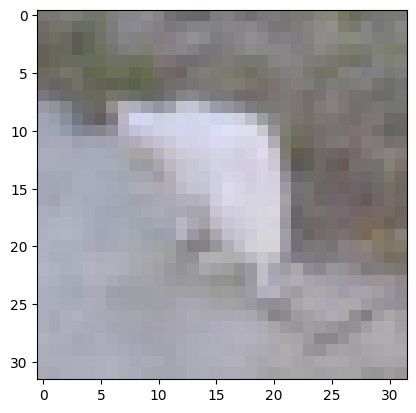

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# 采用 matplotlib 展示图片
image = mpimg.imread('../data/kaggle_cifar10/train/33613.png')
plt.imshow(image)

In [5]:
classe_label={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
label_classe={'airplane':0,'automobile':1,'bird':2,'cat':3,'deer':4,'dog':5,'frog':6,'horse':7,'ship':8,'truck':9}

In [6]:
class CifarDataset(Dataset):

    def __init__(self, train_dir, img_label, transform = None):
        
        self.img_label = img_label
        self.transform = transform
        self.train_dir = train_dir
        

    def __len__(self):
        return len(self.img_label)
    
    def __getitem__(self, index):
        row = self.img_label.iloc[index]
        id = str(row["id"])+".png"
        
        image_path = os.path.join(self.train_dir, id)
        label = str(row["label"])
        label = label_classe[label]
        # image = np.array(Image.open(image_path))
        image = Image.open(image_path)
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [7]:
def load_data(train_dir, img_label, batch_size, train):
    aug = []
    if (train):
        aug = [
            # 在高度和宽度上将图像放大到40像素的正方形
            torchvision.transforms.Resize(40),
            # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
            # 生成一个面积为原始图像面积0.64～1倍的小正方形，
            # 然后将其缩放为高度和宽度均为32像素的正方形
            torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                     ratio=(1.0, 1.0)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            # 标准化图像的每个通道
            torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                             [0.2023, 0.1994, 0.2010])]
    else:
        aug = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])]
    transform = transforms.Compose(aug)
    dataset = CifarDataset(train_dir, img_label, transform)
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0, shuffle=train)

In [8]:
def get_data_loader(NUM_BATCH):
    n_train = len(train_labels)
    train_slices = random.sample(list(range(n_train)), (int)(n_train * 0.9))
    test_slices = list(set(range(n_train)) - set(train_slices))
    train_data = train_labels.iloc[train_slices]
    val_data = train_labels.iloc[test_slices]

    train_dataloader = load_data(train_dir=TRAIN_PATH, img_label=train_data, batch_size=NUM_BATCH, train=True)
    test_dataloader = load_data(train_dir=TRAIN_PATH, img_label=val_data, batch_size=NUM_BATCH, train=False)
    return train_dataloader, test_dataloader

In [9]:
def train(net, train_iter, test_iter, num_epochs, lr, num_gpus, out_dir):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    def accuracy(y_hat, y):
        return (y_hat.argmax(1) == y).sum()

    model_path = os.path.join(out_dir, 'cifar_%s.pth' % (num_epochs))
    result_csv_path = os.path.join(out_dir, 'train_detail_%s.csv' % num_epochs)
    print('model_path:', model_path)
    print('result_csv_path:', result_csv_path)
    net.apply(init_weights)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    print(devices)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    #     trainer = torch.optim.SGD(net.parameters(), lr)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_detail = pd.DataFrame(columns=['train_loss', 'test_loss', 'train acc', 'test acc'])
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train_loss', 'test_loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss_tot, train_acc_tot, train_tot = 0, 0, 0
        test_loss_tot, test_acc_tot, test_tot = 0, 0, 0
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_loss_tot += l * X.shape[0]
                train_acc_tot += accuracy(y_hat, y)
                train_tot += X.shape[0]
        net.eval()
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(devices[0]), y.to(devices[0])
                y_hat = net(X)
                test_loss_tot += l * X.shape[0]
                test_acc_tot += accuracy(y_hat, y)
                test_tot += X.shape[0]
        train_loss = train_loss_tot / train_tot
        train_acc = train_acc_tot / train_tot
        test_acc = test_acc_tot / test_tot
        test_loss = test_loss_tot / test_tot
        animator.add(epoch + 1, (train_loss.cpu(), test_loss.cpu(), train_acc.cpu(), test_acc.cpu()))
        train_detail.loc[len(train_detail)] = [train_loss.cpu(), test_loss.cpu(), train_acc.cpu(), test_acc.cpu()]
        # print('train_loss:', train_loss, '\ttrain_acc', test_acc, '\ttest_acc', test_acc)
        torch.save(net.state_dict(), model_path)
        train_detail.to_csv(result_csv_path, index=False)

In [10]:
train_dataloader, test_dataloader = get_data_loader(512)

272.33979415893555


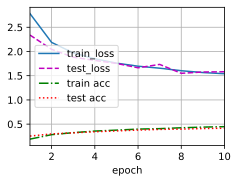

In [11]:
n, timer = 0, d2l.Timer()
EPOCHS = 10
LEARNING_RATE = 0.1e-4
net = torchvision.models.resnet18(num_classes=10)
out_dir = '../data/kaggle_cifar10/model/'
timer.start()
train(net=net, train_iter=train_dataloader, test_iter=test_dataloader,num_epochs=EPOCHS, lr=LEARNING_RATE, num_gpus=1, out_dir= out_dir)
timer.stop()
print(timer.sum())

In [12]:
def infer(pred_iter):
    model = torchvision.models.resnet18(num_classes=2)
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
        
    model.apply(init_weights)
    model.load_state_dict(torch.load('../data/kaggle_cifar10/model/cifar_20.pth'))
    model = model.to('cuda:0')
    model.eval()  # 设置模型为推理模式
    prediction = []
    for X, y in pred_iter:
        X, y = X.to('cuda:0'), y.to('cuda:0')
        print(X.shape)
        y_hat = model(X)
        print(y)
        print(y_hat)
        print(y_hat.argmax(1).cpu())
        break
        
        # X = X.to('cuda:0')
        # prediction.extend(train_labels_header[net(X).argmax(1).cpu()])
    # test_data['label'] = prediction
    # test_data.to_csv(os.path.join(data_dir, 'submission.csv'), index=None)

In [13]:
# infer(test_dataloader)